In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 10.3 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 189 kB 48.8 MB/s 
     |████████████████████████████████| 1.2 MB 19.2 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 51 kB 326 kB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Set Azure-Bing-Search-Key

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '8b63493e9de04d77a6dbc7c794983e0f')
key

'8b63493e9de04d77a6dbc7c794983e0f'

In [ ]:
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls),urls[0]

(100,
 'https://i.cbc.ca/1.4775731.1533917302!/fileImage/httpImage/image.jpg_gen/derivatives/original_780/eyes-of-the-grizzly.jpg')

In [ ]:
urls[1]


'https://d3d0lqu00lnqvz.cloudfront.net/media/media/897b2e5d-6d4c-40fa-bbe8-6829455747e2.jpg'

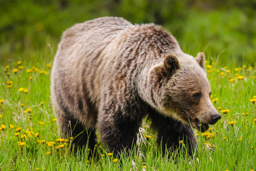

In [ ]:
download_url(urls[1], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

Setting types of cats to classify

In [ ]:
cat_types = 'lion','tiger','panther','leopard','gepard'
path = Path('cats')
cat_types

('lion', 'tiger', 'panther', 'leopard', 'gepard')

Für alle Katzen-Typen Bilder aus bing herunterladen und in einem Verzeichnis mit Namen des Katzentypes speichern

In [ ]:
if not path.exists():
    path.mkdir()
    for o in cat_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
# Liste der Files die heruntergeladen wurden
filenames = get_image_files(path)
filenames

(#685) [Path('cats/lion/00000020.jpg'),Path('cats/lion/00000117.jpg'),Path('cats/lion/00000136.jpg'),Path('cats/lion/00000112.jpg'),Path('cats/lion/00000047.jpg'),Path('cats/lion/00000147.jpg'),Path('cats/lion/00000055.jpg'),Path('cats/lion/00000086.jpg'),Path('cats/lion/00000040.jpg'),Path('cats/lion/00000070.jpeg')...]

Ungültge Files entfernen

In [ ]:
failed = verify_images(filenames)
failed.map(Path.unlink)


(#7) [None,None,None,None,None,None,None]

Datablock anlegen und Dataloader

In [ ]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
cats_dataloader = cats.dataloaders(path)

Einige Bilder anschauen

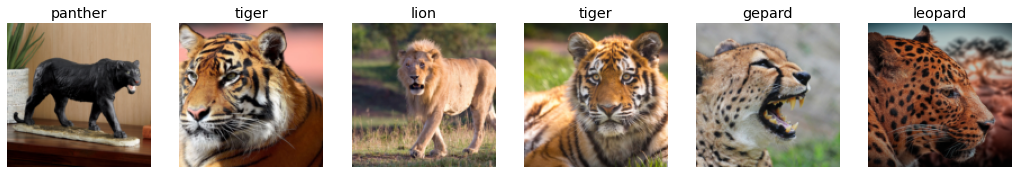

In [ ]:
cats_dataloader.valid.show_batch(max_n=6, nrows=1)

Daten aufbessern

In [ ]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
cats_dataloader = cats.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


Und Bilder checken

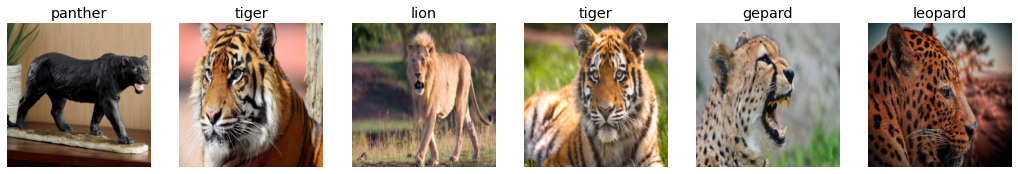

In [ ]:
cats_dataloader.valid.show_batch(max_n=6, nrows=1)

Nun Learner anlegen und das Modell trainieren

In [ ]:
learn = cnn_learner(cats_dataloader, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.786119,0.322308,0.096296,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.395794,0.225930,0.074074,00:38
1,0.315240,0.196617,0.037037,00:38
2,0.261282,0.232861,0.051852,00:38
3,0.205788,0.259503,0.051852,00:39
4,0.177158,0.257785,0.051852,00:38


Checken, wieviele Bilder im Valid richtig erkannt wurden

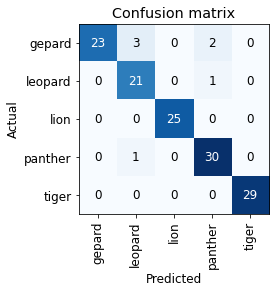

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**Jetzt eine Applikation bauen**

Das trainierte MOdell sichern und wieder laden

In [ ]:
learn.export()
learn_inf = load_learner('export.pkl')

Zum Test eine Bild-Prediction durchführen

In [ ]:
learn_inf.predict('cats/tiger/00000000.jpg')

('tiger',
 TensorBase(4),
 TensorBase([1.0429e-07, 6.3891e-06, 1.0635e-06, 1.3564e-07, 9.9999e-01]))

Und das Vocabular anzeigen lassen

In [ ]:
learn_inf.dls.vocab

['gepard', 'leopard', 'lion', 'panther', 'tiger']

Jetzt mit Widgets ein Bild laden und klassifizieren

In [ ]:

#hide_output
out_pl = widgets.Output()

#hide_output
lbl_pred = widgets.Label()
#lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

#hide_output
btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])